# A. Prepare and Inspect Data

## 1. Load the Dataset

In [ ]:
%pip install missingno
%pip install mxnet
!pip install umap-learn

# Data Manipulation
import pandas as pd

# Data Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Additional Libraries
import tarfile
# import mxnet as mx
import datetime
import json
import time
from tabulate import tabulate
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
from sklearn.metrics import silhouette_score
import missingno as msno
import sklearn.preprocessing as preprocessing
import missingno as msno

import numpy as np

# Monkey-patch before any other library imports use NumPy
if not hasattr(np, "bool"):
    np.bool = bool

import mxnet as mx


from scipy.spatial.distance import cdist
import gc

from sklearn.metrics import silhouette_score
import numpy as np
import tarfile
import seaborn as sns
import matplotlib.pyplot as plt



import io, tarfile, joblib, gc
from sklearn.model_selection import train_test_split
from sagemaker import estimator
from sagemaker.inputs import TrainingInput
from sagemaker.tuner import HyperparameterTuner, IntegerParameter, CategoricalParameter
from sagemaker.amazon.common import write_numpy_to_dense_tensor
import boto3, json


from sagemaker.model import Model
from sagemaker.predictor import Predictor
from sagemaker.serializers import CSVSerializer


# PCA
from sklearn.decomposition import PCA

In [ ]:
# Step 1: Load the Dataset
# Load the mall customers dataset from a CSV file into a Pandas DataFrame.
# This allows for easy data manipulation and analysis.
df = pd.read_csv('Telecom_customer churn.csv')

# # Step 2: Select Relevant Features
# # Focus on the features ''Annual Income (k$)', and 'Spending Score (1-100)' for analysis.
# df = df[['Annual Income (k$)', 'Spending Score (1-100)']]

# # Step 3: Convert Data for Machine Learning
# # Convert the selected DataFrame into a NumPy array of type 'float32'.
# # This conversion is necessary as most machine learning frameworks work efficiently with NumPy arrays.
# data_np = df.values.astype('float32')

# # Step 4: Save Preprocessed Data
# # Save the preprocessed dataset to a CSV file, without the index.
# df.to_csv('mall_data-one-a.csv', index=False)

# # Confirming the data has been preprocessed and saved.
# print("Preprocessed dataset saved as 'mall_data-one-a.csv'.")

# Display the first few rows of the processed dataset to verify the preprocessing steps.
print(df.head())

## 2. Decide which Features to Include

In [3]:
columns_to_drop = ['numbcars','dwllsize','HHstatin','ownrent','dwlltype','lor','income','adults','prizm_social_one','infobase','crclscod', 'Customer_ID']

df.drop(columns_to_drop, axis=1, inplace=True)

## 3. Handle Missing Values

### 3.1. Analyzing Missing Values

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 88 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   rev_Mean         99643 non-null   float64
 1   mou_Mean         99643 non-null   float64
 2   totmrc_Mean      99643 non-null   float64
 3   da_Mean          99643 non-null   float64
 4   ovrmou_Mean      99643 non-null   float64
 5   ovrrev_Mean      99643 non-null   float64
 6   vceovr_Mean      99643 non-null   float64
 7   datovr_Mean      99643 non-null   float64
 8   roam_Mean        99643 non-null   float64
 9   change_mou       99109 non-null   float64
 10  change_rev       99109 non-null   float64
 11  drop_vce_Mean    100000 non-null  float64
 12  drop_dat_Mean    100000 non-null  float64
 13  blck_vce_Mean    100000 non-null  float64
 14  blck_dat_Mean    100000 non-null  float64
 15  unan_vce_Mean    100000 non-null  float64
 16  unan_dat_Mean    100000 non-null  float

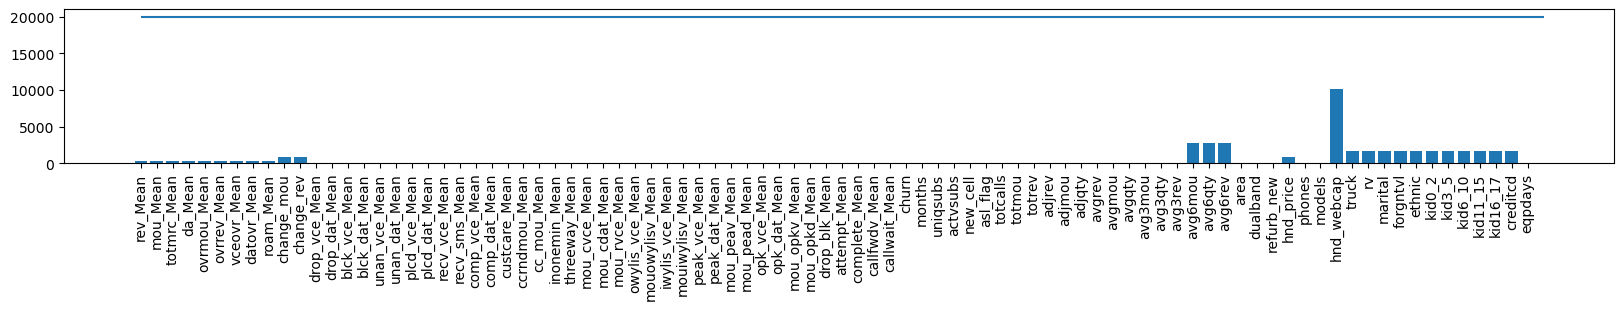

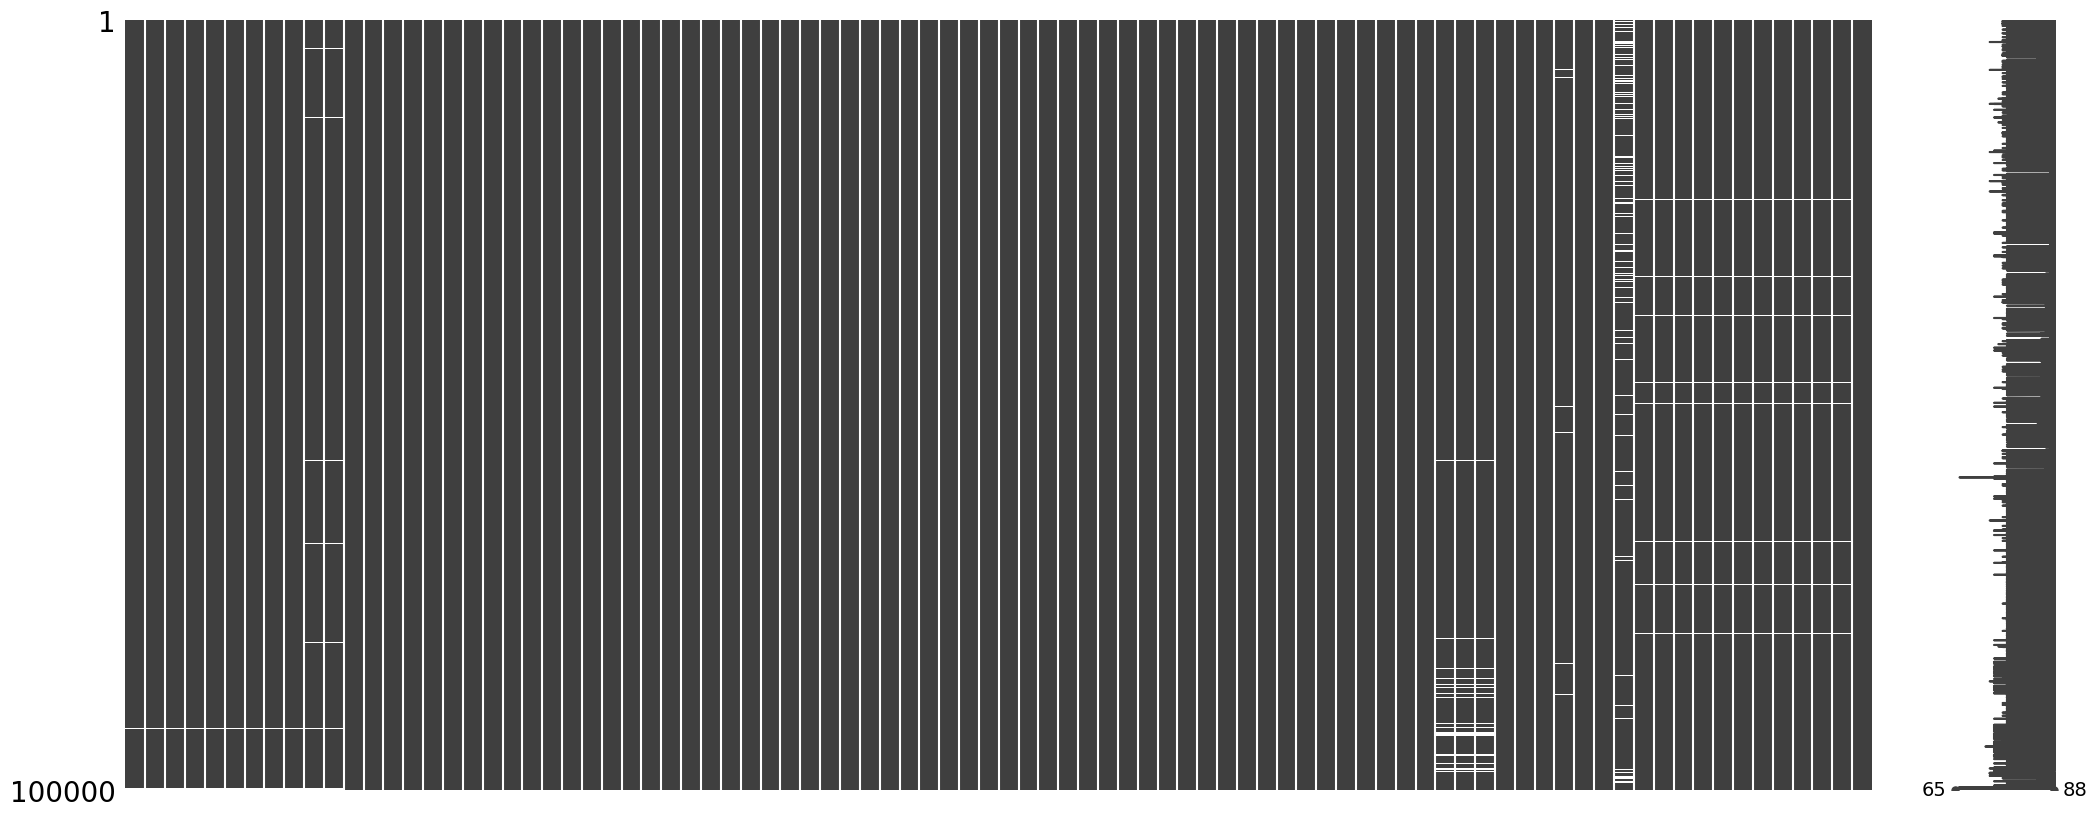

In [6]:
DROP_THREASHOLD = 0.20


plt.figure(figsize=(20,2))
plt.bar(df.columns, df.isna().sum())
plt.hlines(y=100000*DROP_THREASHOLD, xmin=0, xmax=df.columns.shape)
plt.xticks(rotation=90)
plt.show()

msno.matrix(df)
plt.show()

# plt.figure(figsize=(30,2))
# sns.heatmap(df)
# plt.bar(df.columns, df.isna().sum())
# plt.show()

# plt.plot()
# df.isna().sum()

### 3.2. Drop Columns with Too Many Missing Values


In [7]:
def drop_high_missing_columns(dataframe, threshold=0.3):
    """
    Drop any column that has a fraction of missing values 
    greater than the given threshold (default=0.3).
    
    For example, 0.3 means 30% of that column's values are missing.
    """
    # fraction of missing values for each column
    missing_fraction = dataframe.isnull().mean()
    
    # which columns are above the threshold
    cols_to_drop = missing_fraction[missing_fraction > threshold].index
    print(f"Columns to drop (>{threshold*100}% missing):", list(cols_to_drop))
    
    # drop them in place
    dataframe.drop(columns=cols_to_drop, inplace=True)
    
    return dataframe

drop_high_missing_columns(df, DROP_THREASHOLD)
df

Columns to drop (>20.0% missing): []


rev_Mean  mou_Mean  totmrc_Mean  da_Mean  ovrmou_Mean  ovrrev_Mean  \
0       23.9975    219.25       22.500   0.2475         0.00          0.0   
1       57.4925    482.75       37.425   0.2475        22.75          9.1   
2       16.9900     10.25       16.990   0.0000         0.00          0.0   
3       38.0000      7.50       38.000   0.0000         0.00          0.0   
4       55.2300    570.50       71.980   0.0000         0.00          0.0   
...         ...       ...          ...      ...          ...          ...   
99995       NaN       NaN          NaN      NaN          NaN          NaN   
99996       NaN       NaN          NaN      NaN          NaN          NaN   
99997       NaN       NaN          NaN      NaN          NaN          NaN   
99998       NaN       NaN          NaN      NaN          NaN          NaN   
99999       NaN       NaN          NaN      NaN          NaN          NaN   

       vceovr_Mean  datovr_Mean  roam_Mean  change_mou  ...  marital  \
0              0.0          0.0        0.0     -157.25  ...        S   
1              9.1          0.0        0.0      532.25  ...        S   
2              0.0          0.0        0.0       -4.25  ...        M   
3              0.0          0.0        0.0       -1.50  ...        M   
4              0.0          0.0        0.0       38.50  ...        S   
...            ...          ...        ...         ...  ...      ...   
99995          NaN          NaN        NaN         NaN  ...        M   
99996          NaN          NaN        NaN         NaN  ...        M   
99997          NaN          NaN        NaN         NaN  ...        B   
99998          NaN          NaN        NaN         NaN  ...        U   
99999          NaN          NaN        NaN         NaN  ...        A   

       forgntvl  ethnic  kid0_2  kid3_5  kid6_10  kid11_15  kid16_17  \
0           0.0       N       U       U        U         U         U   
1           0.0       Z       U       U        U         U         U   
2           0.0       N       U       Y        U         U         U   
3           0.0       U       Y       U        U         U         U   
4           0.0       I       U       U        U         U         U   
...         ...     ...     ...     ...      ...       ...       ...   
99995       0.0       S       U       U        U         Y         U   
99996       0.0       N       U       U        Y         Y         Y   
99997       0.0       U       Y       Y        U         U         U   
99998       0.0       S       U       U        U         U         U   
99999       0.0       H       U       U        U         U         U   

       creditcd  eqpdays  
0             Y    361.0  
1             Y    240.0  
2             Y   1504.0  
3             Y   1812.0  
4             Y    434.0  
...         ...      ...  
99995         Y    773.0  
99996         Y    835.0  
99997         N    433.0  
99998         N     75.0  
99999         N      5.0  

[100000 rows x 88 columns]

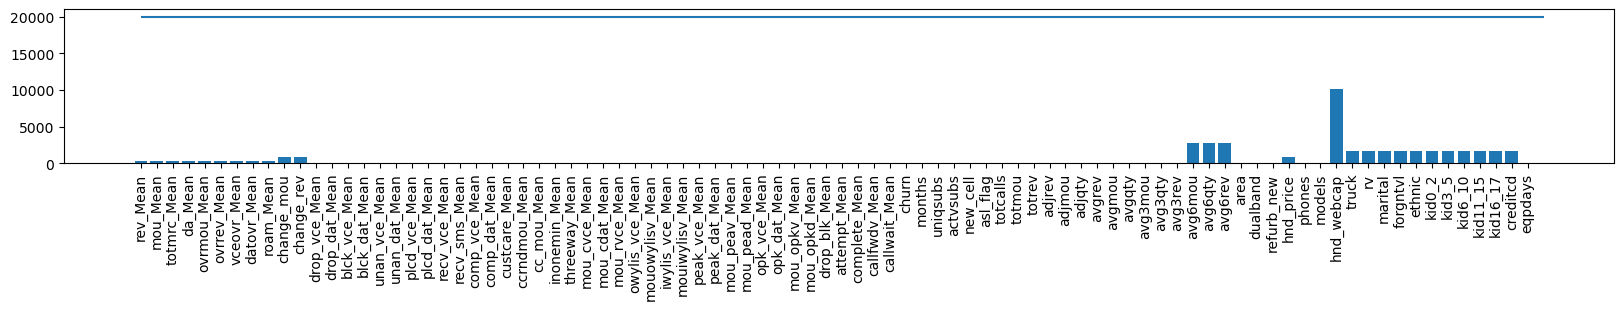

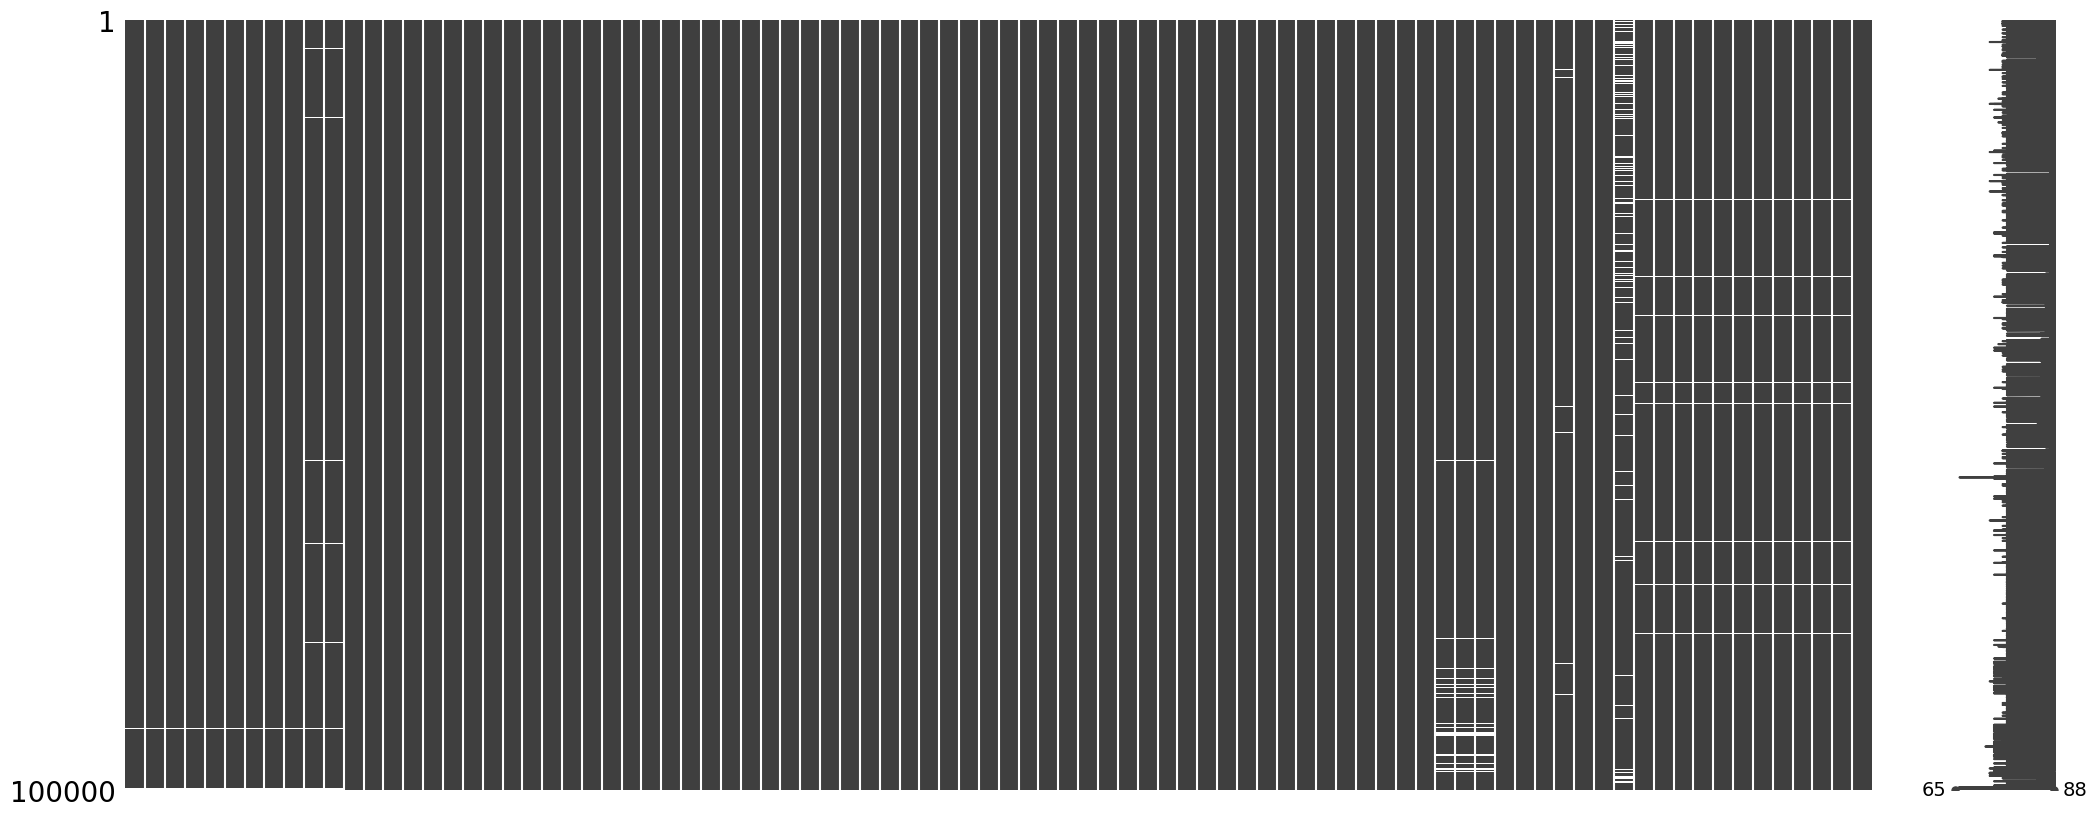

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 88 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   rev_Mean         99643 non-null   float64
 1   mou_Mean         99643 non-null   float64
 2   totmrc_Mean      99643 non-null   float64
 3   da_Mean          99643 non-null   float64
 4   ovrmou_Mean      99643 non-null   float64
 5   ovrrev_Mean      99643 non-null   float64
 6   vceovr_Mean      99643 non-null   float64
 7   datovr_Mean      99643 non-null   float64
 8   roam_Mean        99643 non-null   float64
 9   change_mou       99109 non-null   float64
 10  change_rev       99109 non-null   float64
 11  drop_vce_Mean    100000 non-null  float64
 12  drop_dat_Mean    100000 non-null  float64
 13  blck_vce_Mean    100000 non-null  float64
 14  blck_dat_Mean    100000 non-null  float64
 15  unan_vce_Mean    100000 non-null  float64
 16  unan_dat_Mean    100000 non-null  float

In [7]:
plt.figure(figsize=(20,2))
plt.bar(df.columns, df.isna().sum())
plt.hlines(y=20000, xmin=0, xmax=df.columns.shape)
plt.xticks(rotation=90)
plt.show()
msno.matrix(df)
plt.show()
df.info()

### 3.3. Fill Missing Values

In [8]:
df['hnd_webcap']=df['hnd_webcap'].fillna('UNKW') # Handset web capability

df['avg6qty']=df['avg6qty'].fillna(df['avg6qty'].mean()) # Billing adjusted total number of calls over the life of the customer
df['avg6rev']=df['avg6rev'].fillna(df['avg6rev'].mean()) # Average monthly revenue over the life of the customer
df['avg6mou']=df['avg6mou'].fillna(df['avg6mou'].mean()) # Average monthly minutes of use over the life of the customer

df['change_mou']=df['change_mou'].fillna(df['change_mou'].mean()) # Percentage change in monthly minutes of use vs previous three month average
df['change_rev']=df['change_rev'].fillna(df['change_rev'].mean()) # Percentage change in monthly revenue vs previous three month average

df['rev_Mean']=df['rev_Mean'].fillna(df['rev_Mean'].mean())
df['totmrc_Mean']=df['totmrc_Mean'].fillna(df['totmrc_Mean'].mean())
df['da_Mean']=df['da_Mean'].fillna(df['da_Mean'].mean())
df['ovrmou_Mean']=df['ovrmou_Mean'].fillna(df['ovrmou_Mean'].mean())
df['ovrrev_Mean']=df['ovrrev_Mean'].fillna(df['ovrrev_Mean'].mean())
df['vceovr_Mean']=df['vceovr_Mean'].fillna(df['vceovr_Mean'].mean())
df['datovr_Mean']=df['datovr_Mean'].fillna(df['datovr_Mean'].mean())
df['roam_Mean']=df['roam_Mean'].fillna(df['roam_Mean'].mean())
df['mou_Mean']=df['mou_Mean'].fillna(df['mou_Mean'].mean())

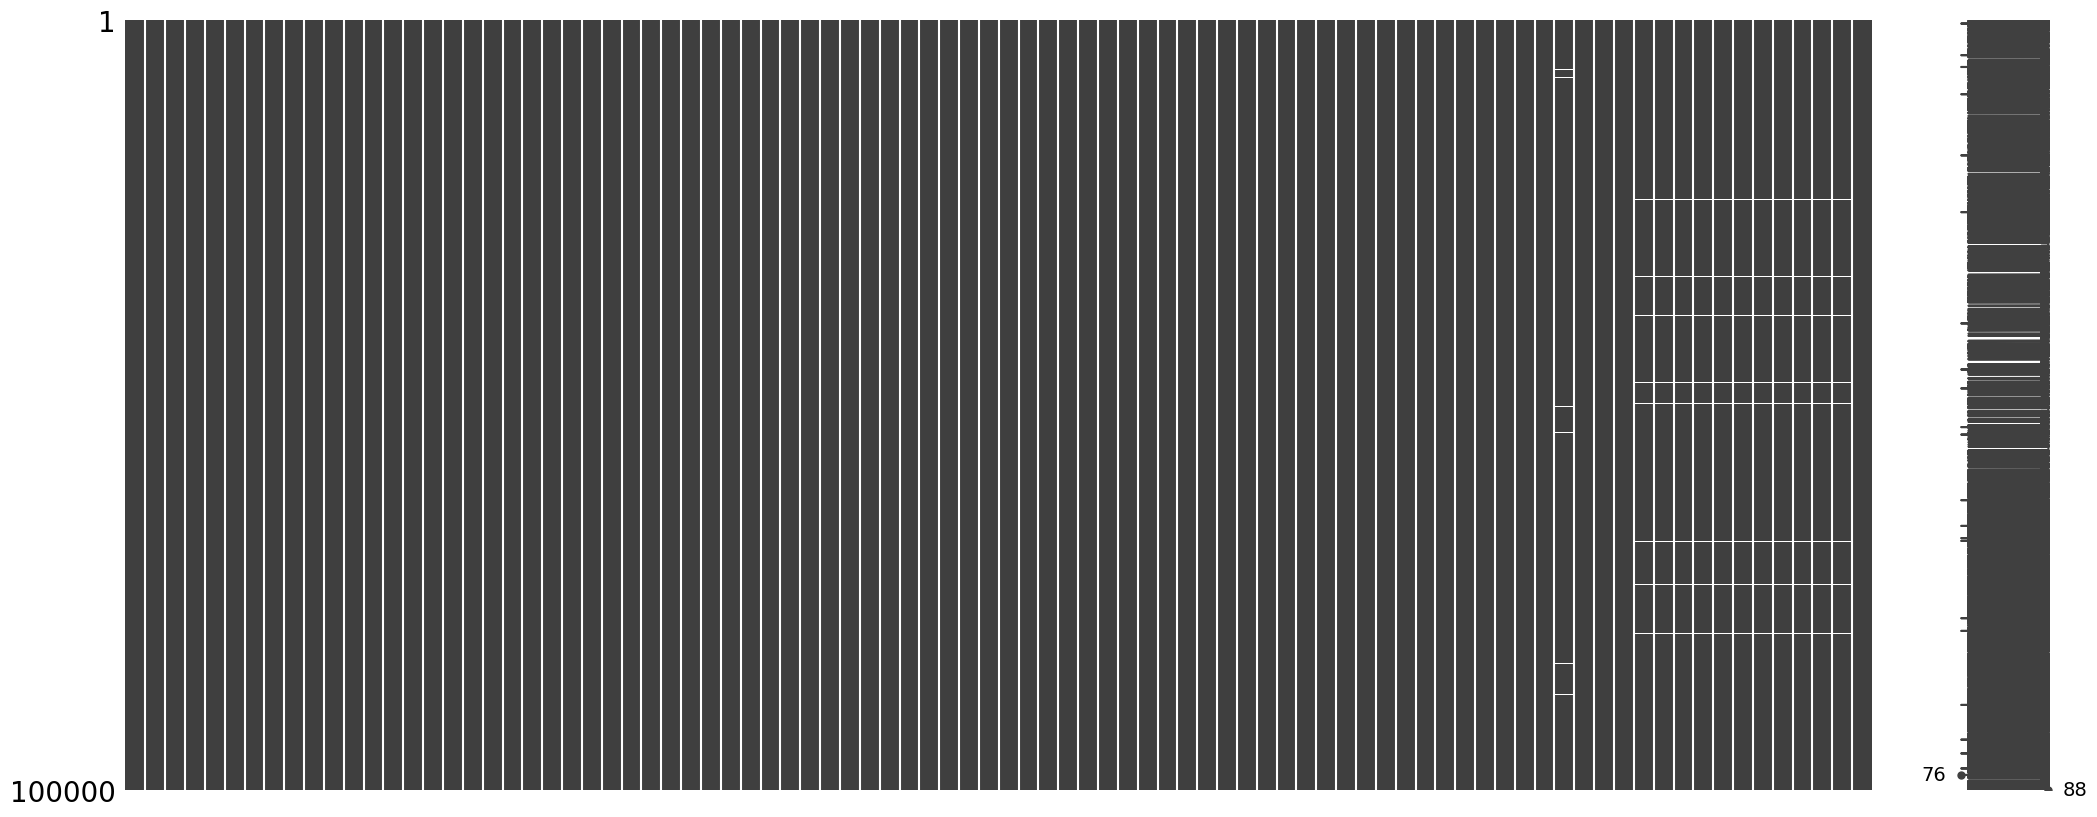

['area',
 'dualband',
 'refurb_new',
 'hnd_price',
 'phones',
 'models',
 'truck',
 'rv',
 'marital',
 'forgntvl',
 'ethnic',
 'kid0_2',
 'kid3_5',
 'kid6_10',
 'kid11_15',
 'kid16_17',
 'creditcd',
 'eqpdays']

In [9]:
msno.matrix(df)
plt.show()
[col for col in df.columns if df[col].isnull().any()]

### 3.4. Drop Rows with Missing Values

In [10]:
df.dropna(inplace=True)

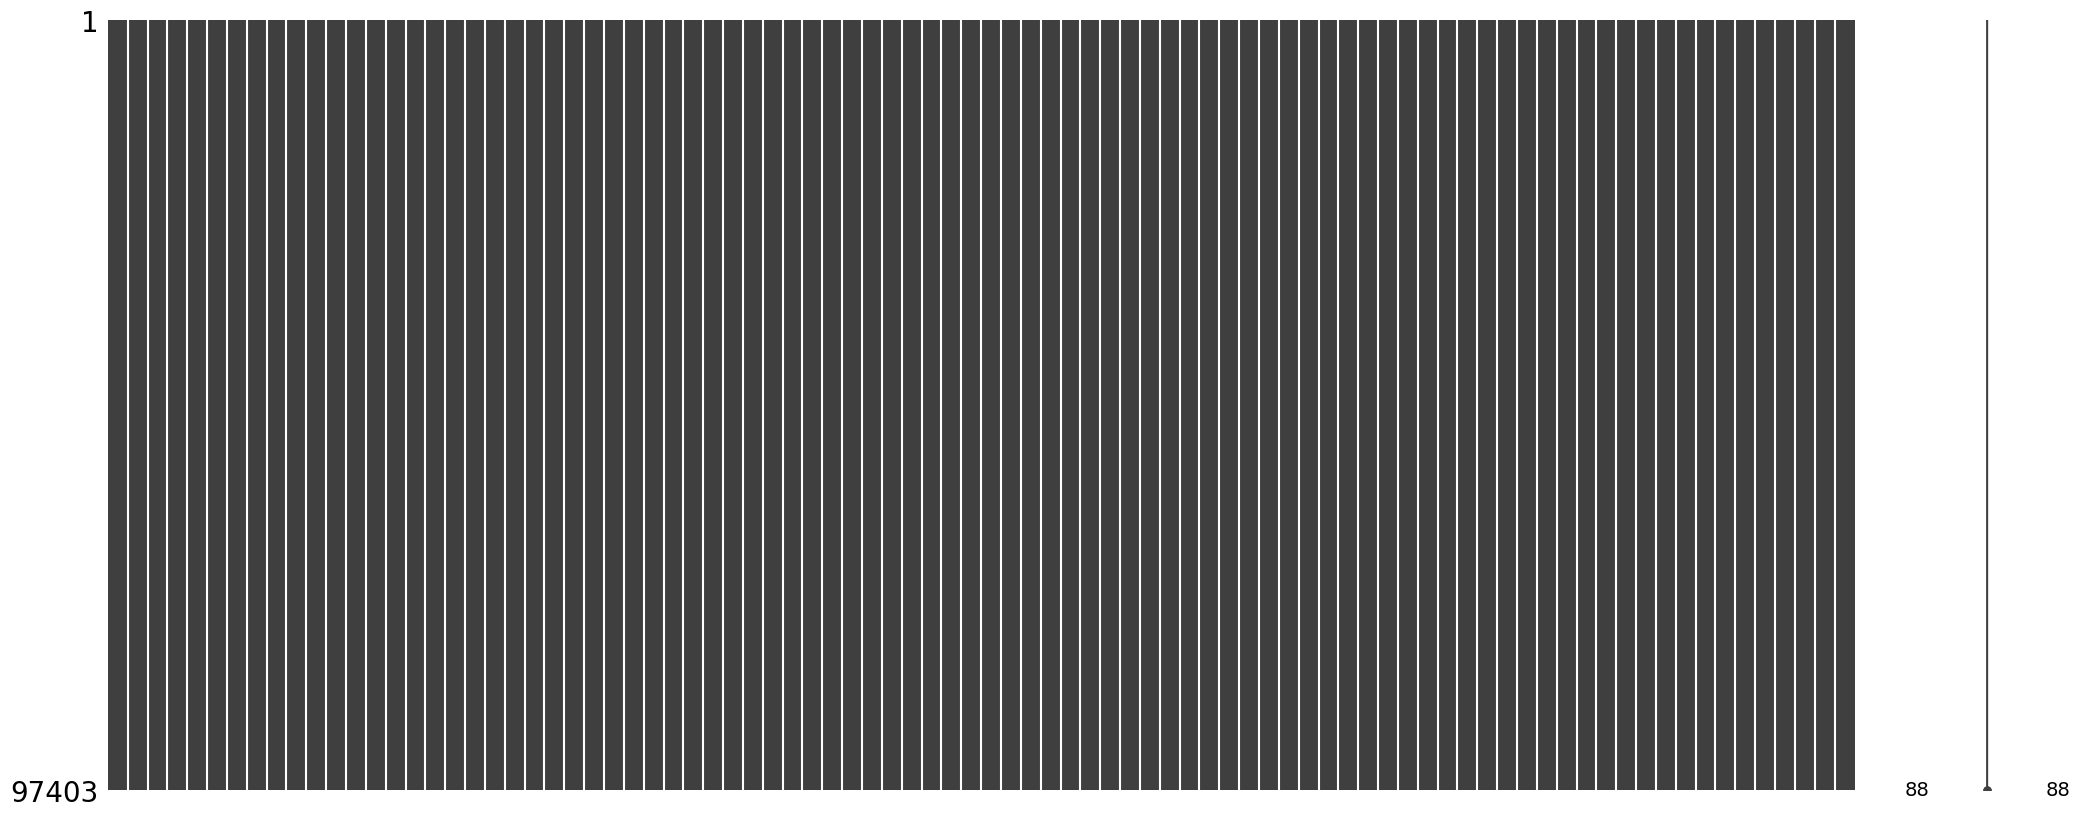

[]

In [11]:
msno.matrix(df)
plt.show()
[col for col in df.columns if df[col].isnull().any()]

## 4. Normalize Data

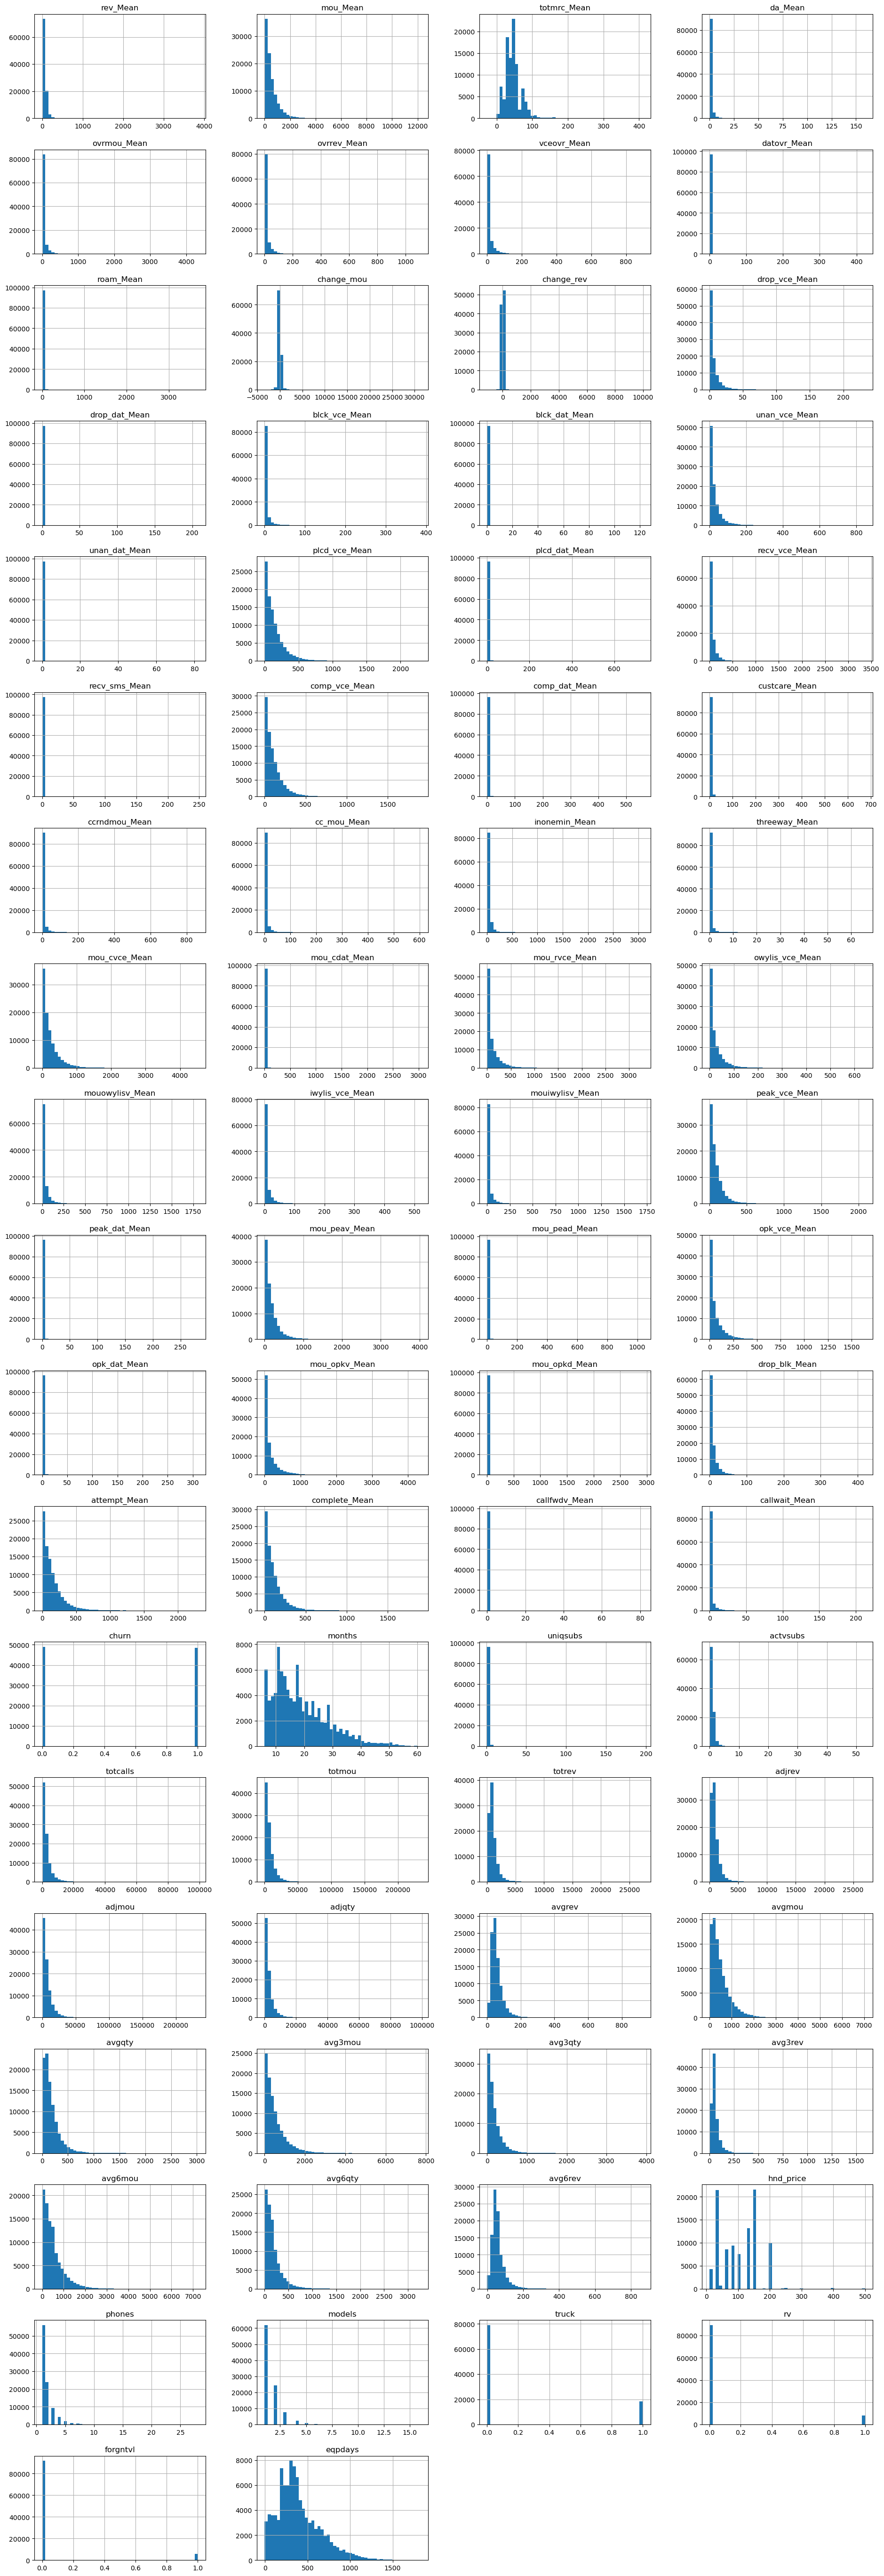

In [12]:
df.iloc[:,:].hist(bins=50,figsize=(23,74),layout=(20,4))
plt.show()

In [13]:
numerical_features = ['months', 'uniqsubs', 'actvsubs', 'totcalls', 'avg3qty', 'avg3rev','rev_Mean', 'mou_Mean', 'totmrc_Mean', 'da_Mean', 'ovrmou_Mean', 'datovr_Mean', 
                      'roam_Mean', 'change_mou', 'change_rev', 'drop_vce_Mean', 'drop_dat_Mean', 'blck_vce_Mean', 'blck_dat_Mean', 'unan_vce_Mean', 'unan_dat_Mean', 
                      'plcd_vce_Mean', 'plcd_dat_Mean', 'recv_vce_Mean', 'recv_sms_Mean', 'custcare_Mean', 'ccrndmou_Mean', 'threeway_Mean', 'mou_cvce_Mean', 
                      'mou_cdat_Mean', 'mou_rvce_Mean', 'owylis_vce_Mean', 'mouowylisv_Mean', 'iwylis_vce_Mean', 'mouiwylisv_Mean', 'peak_vce_Mean', 'peak_dat_Mean', 
                      'mou_peav_Mean', 'mou_pead_Mean', 'opk_vce_Mean', 'opk_dat_Mean', 'mou_opkv_Mean', 'drop_blk_Mean', 'callfwdv_Mean', 'callwait_Mean', 'totmou', 
                      'totrev', 'avgrev', 'avgmou', 'avgqty', 'avg6mou', 'avg6rev', 'hnd_price', 'phones', 'models', 'truck', 'rv', 'forgntvl', 'eqpdays']

f_sqrt = (lambda x: np.sqrt(abs(x)) if (x>=1) or (x<=-1) else x)

for i in numerical_features:    
    df[i] = df[i].apply(f_sqrt)
    


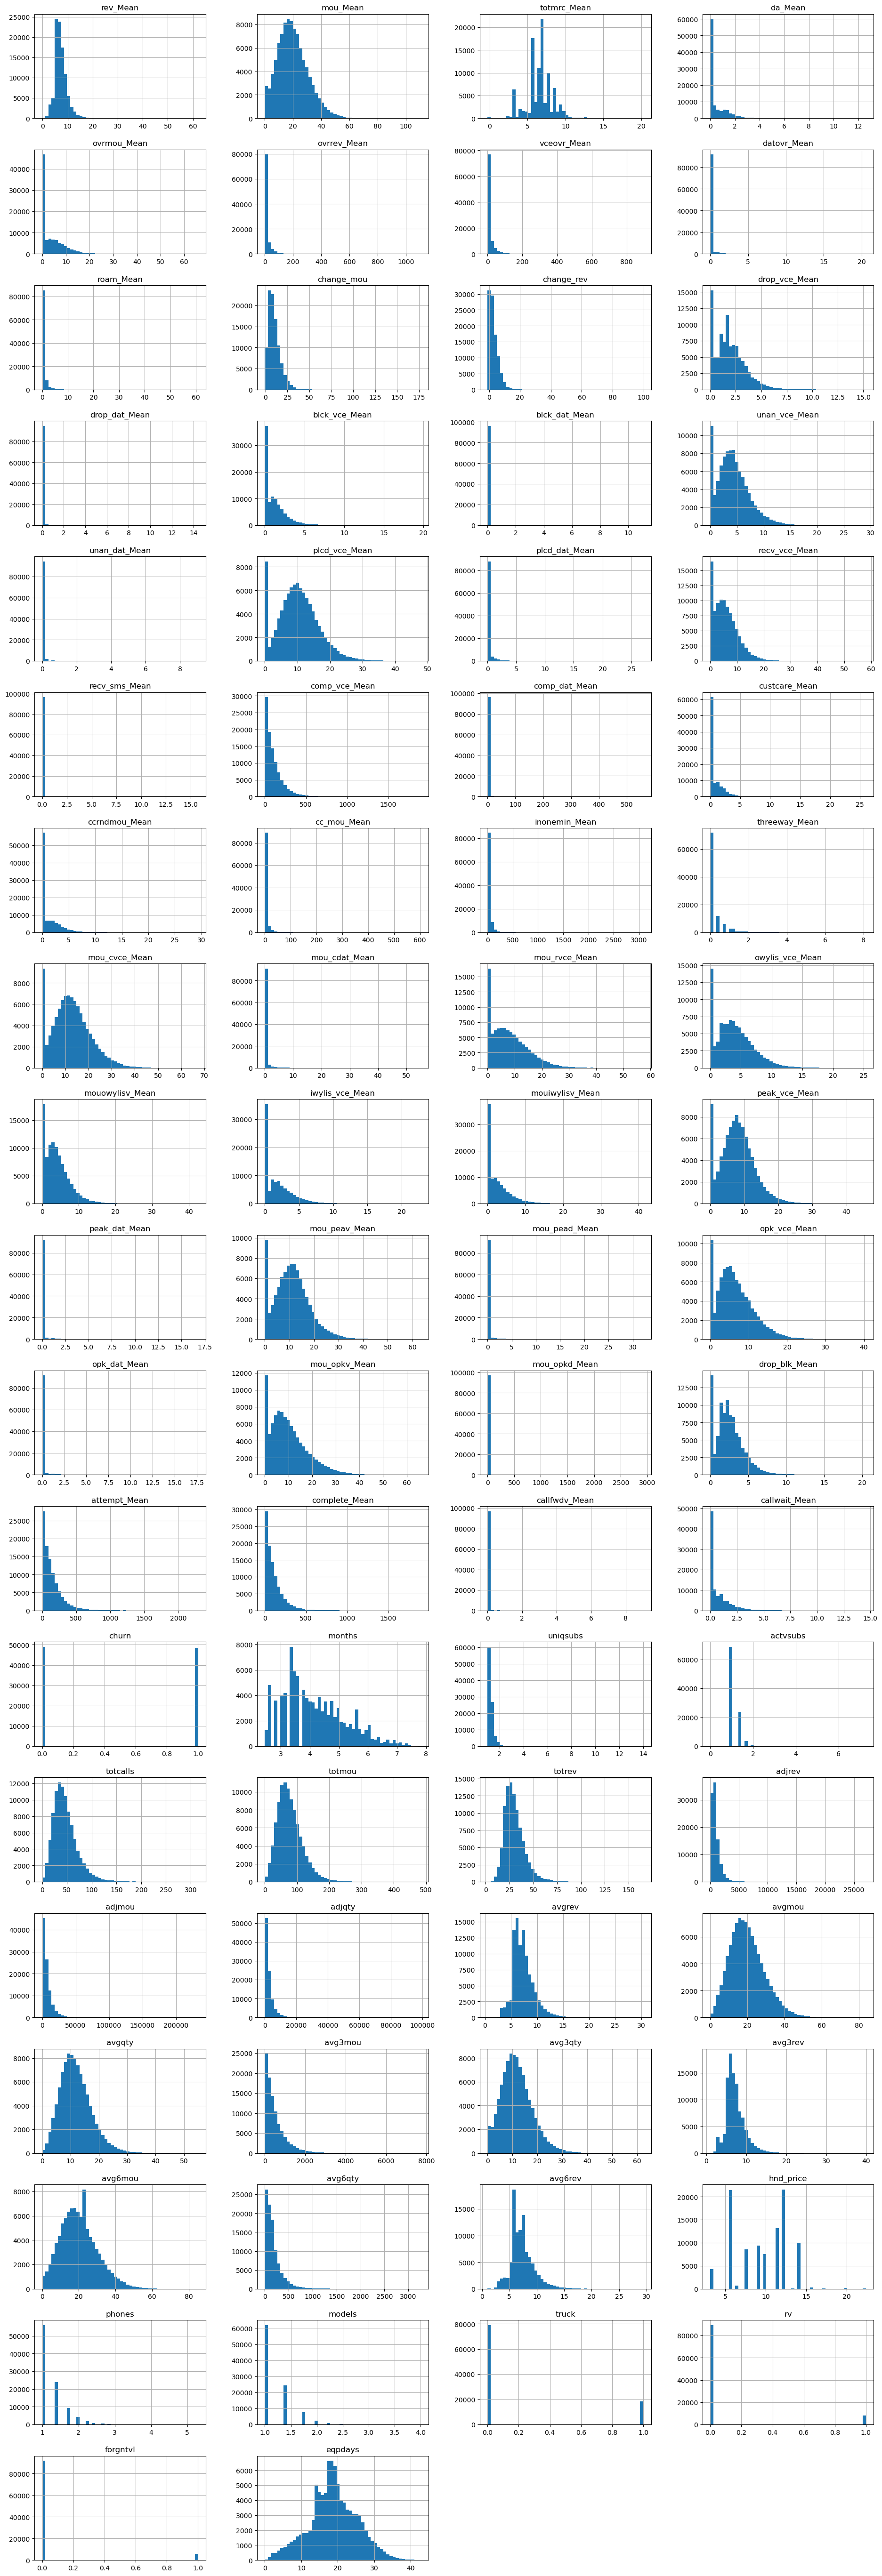

In [14]:
df.iloc[:,:].hist(bins=50,figsize=(23,74),layout=(20,4))
plt.show()

## 5. Encode Categorical Features

decipher: 
- martial status
- Handset web capability
- crclscod
- new cell phone user


In [15]:
print(df.select_dtypes(exclude='number').columns)

Index(['new_cell', 'asl_flag', 'area', 'dualband', 'refurb_new', 'hnd_webcap',
       'marital', 'ethnic', 'kid0_2', 'kid3_5', 'kid6_10', 'kid11_15',
       'kid16_17', 'creditcd'],
      dtype='object')


In [16]:
encoding = []
for i in df.select_dtypes(include='object'):   
    encoding.append(i)
    print(i, df[i].nunique())
encoding

new_cell 3
asl_flag 2
area 19
dualband 3
refurb_new 2
hnd_webcap 3
marital 5
ethnic 17
kid0_2 2
kid3_5 2
kid6_10 2
kid11_15 2
kid16_17 2
creditcd 2


['new_cell',
 'asl_flag',
 'area',
 'dualband',
 'refurb_new',
 'hnd_webcap',
 'marital',
 'ethnic',
 'kid0_2',
 'kid3_5',
 'kid6_10',
 'kid11_15',
 'kid16_17',
 'creditcd']

In [17]:
fedf = df.copy()
fedf = pd.get_dummies(fedf, drop_first=False, columns=encoding, prefix=encoding)
fedf

rev_Mean   mou_Mean  totmrc_Mean   da_Mean  ovrmou_Mean  ovrrev_Mean  \
0      4.898724  14.807093     4.743416  0.247500     0.000000      0.00000   
2      4.121893   3.201562     4.121893  0.000000     0.000000      0.00000   
3      6.164414   2.738613     6.164414  0.000000     0.000000      0.00000   
4      7.431689  23.885142     8.484103  0.000000     0.000000      0.00000   
5      9.070557  36.224991     8.660254  1.112430     0.000000      0.00000   
...         ...        ...          ...       ...          ...          ...   
99995  7.662897  22.661861     6.795523  0.888828     6.408763     13.55956   
99996  7.662897  22.661861     6.795523  0.888828     6.408763     13.55956   
99997  7.662897  22.661861     6.795523  0.888828     6.408763     13.55956   
99998  7.662897  22.661861     6.795523  0.888828     6.408763     13.55956   
99999  7.662897  22.661861     6.795523  0.888828     6.408763     13.55956   

       vceovr_Mean  datovr_Mean  roam_Mean  change_mou  ...  kid3_5_U  \
0         0.000000     0.000000   0.000000   12.539936  ...         1   
2         0.000000     0.000000   0.000000    2.061553  ...         0   
3         0.000000     0.000000   0.000000    1.224745  ...         1   
4         0.000000     0.000000   0.000000    6.204837  ...         1   
5         0.000000     0.000000   0.000000   12.519984  ...         1   
...            ...          ...        ...         ...  ...       ...   
99995    13.295062     0.261318   1.134198    3.732803  ...         1   
99996    13.295062     0.261318   1.134198    3.732803  ...         1   
99997    13.295062     0.261318   1.134198    3.732803  ...         0   
99998    13.295062     0.261318   1.134198    3.732803  ...         1   
99999    13.295062     0.261318   1.134198    3.732803  ...         1   

       kid3_5_Y  kid6_10_U  kid6_10_Y  kid11_15_U  kid11_15_Y  kid16_17_U  \
0             0          1          0           1           0           1   
2             1          1          0           1           0           1   
3             0          1          0           1           0           1   
4             0          1          0           1           0           1   
5             0          1          0           1           0           1   
...         ...        ...        ...         ...         ...         ...   
99995         0          1          0           0           1           1   
99996         0          0          1           0           1           0   
99997         1          1          0           1           0           1   
99998         0          1          0           1           0           1   
99999         0          1          0           1           0           1   

       kid16_17_Y  creditcd_N  creditcd_Y  
0               0           0           1  
2               0           0           1  
3               0           0           1  
4               0           0           1  
5               0           0           1  
...           ...         ...         ...  
99995           0           0           1  
99996           1           0           1  
99997           0           1           0  
99998           0           1           0  
99999           0           1           0  

[97403 rows x 140 columns]

## 6. Scale Data

In [18]:
scaler = preprocessing.MinMaxScaler()

ready_data = scaler.fit_transform(fedf)

rdf = pd.DataFrame(ready_data, columns=fedf.columns, index=fedf.index)

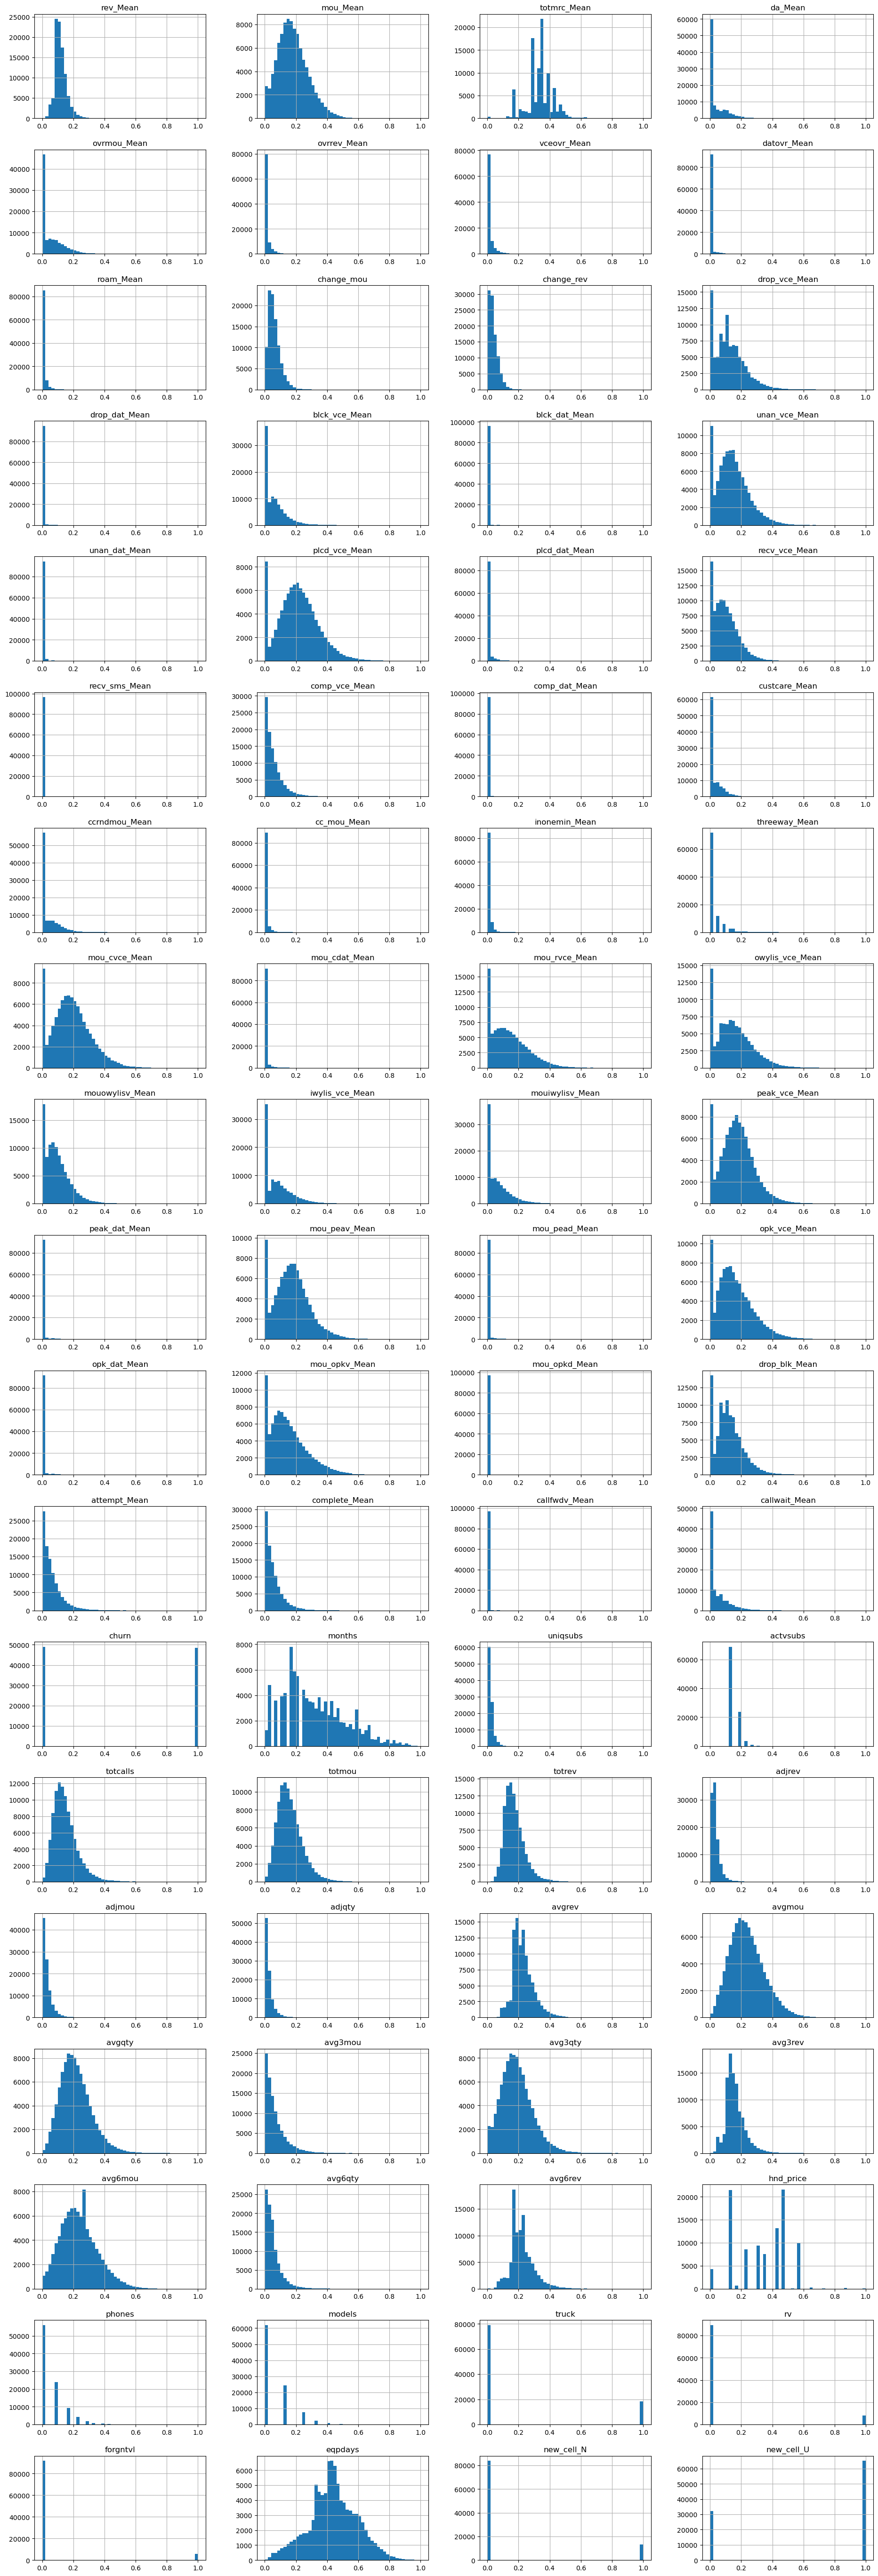

In [20]:
rdf.iloc[:,:76].hist(bins=50,figsize=(23,74),layout=(20,4))
plt.show()

df - raw dataframe where we dropped the features we don't want, categorical values are still letters and in their categories, not normalized

fedf - encoded categorical features into one-hot binary features, not normalized

rdf - encoded categorical features into one-hot binary features, NORMALIZED

## 7. Dimensionality Reduction

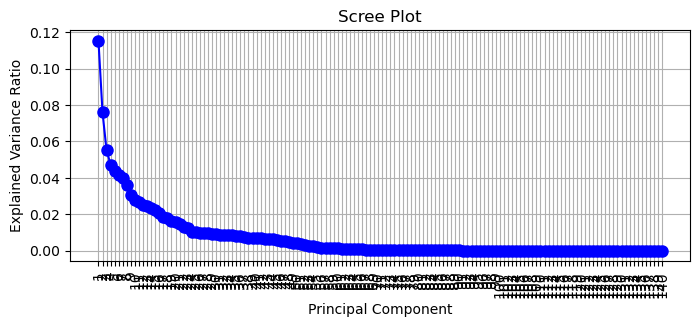

In [21]:
# Fit PCA on the normalized data 'rdf'
pca = PCA()
pca.fit(rdf)

# Get the explained variance ratio for each component
explained_variance = pca.explained_variance_ratio_

# Generate the scree plot
plt.figure(figsize=(8, 3))
plt.plot(np.arange(1, len(explained_variance) + 1), explained_variance, 'bo-', markersize=8)
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')
plt.title('Scree Plot')
plt.xticks(np.arange(1, len(explained_variance) + 1), rotation=90)
plt.grid(True)
plt.show()


In [22]:
pca_30 = PCA(n_components=30).fit_transform(rdf)
pca_30.shape

(97403, 30)

### 7.1 UMAP 30D -> 2D Dimensionality Reduction

In [23]:
import umap

# Apply UMAP to reduce to 2D
umap_reducer = umap.UMAP(n_components=2, n_neighbors=30, min_dist=0.1)
umap_result = umap_reducer.fit_transform(pca_30)
umap_result.shape

/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


(97403, 2)

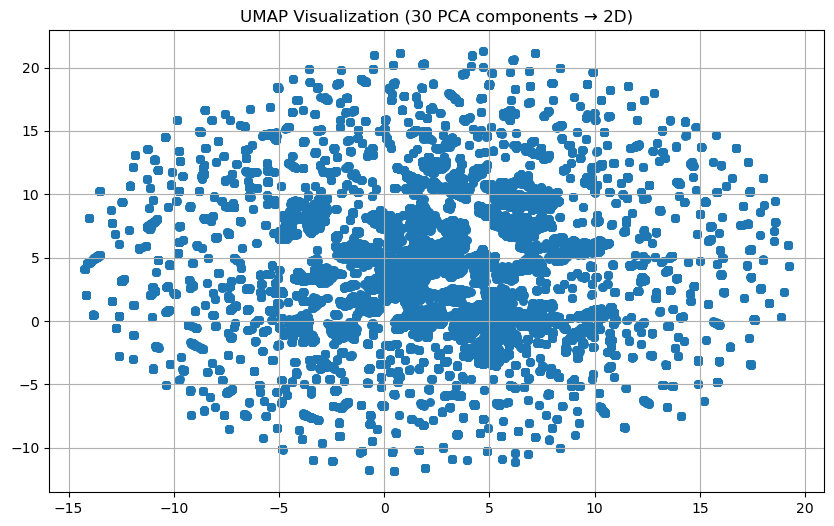

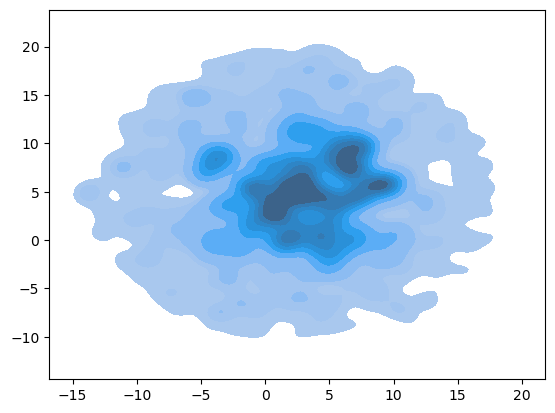

In [20]:
samples = 100_000


# Plot
plt.figure(figsize=(10, 6))
plt.scatter(umap_result[:samples, 0], umap_result[:samples, 1], s=30)
plt.title("UMAP Visualization (30 PCA components → 2D)")
plt.grid(True)
plt.show()


sns.kdeplot(x=umap_result[:samples, 0], y=umap_result[:samples, 1], fill=True,)
plt.show()

# B. Prepare the Environment

## 1. Sagemaker Library Imports and Setup

In [24]:
# # Install the mxnet library required for certain functionalities in SageMaker
%pip install mxnet

# # AWS SageMaker and Boto3
import sagemaker
from sagemaker import get_execution_role, KMeans
from sagemaker.image_uris import retrieve
from sagemaker.model import Model
from sagemaker.predictor import Predictor
from sagemaker.serializers import CSVSerializer
import boto3
from botocore.exceptions import ClientError

import joblib

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score

from mpl_toolkits.mplot3d import Axes3D


from sklearn.decomposition import PCA
import matplotlib.cm as cm

Note: you may need to restart the kernel to use updated packages.


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/pydantic/_internal/_fields.py:192: UserWarning: Field name "json" in "MonitoringDatasetFormat" shadows an attribute in parent "Base"
  warnings.warn(


[03/30/25 18:45:28] INFO     Found credentials from IAM Role:                                   ]8;id=729594;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/botocore/credentials.py\credentials.py]8;;\:]8;id=492178;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/botocore/credentials.py#1132\1132]8;;\
                             BaseNotebookInstanceEc2InstanceRole                                                   

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/ec2-user/.config/sagemaker/config.yaml


In [25]:
# Initialize a SageMaker Session
# A SageMaker Session helps in managing the interactions with the AWS SageMaker service, such as creating and training models, and deploying endpoints.
sagemaker_session = sagemaker.Session()

# Retrieve the IAM role
# The IAM role is required by SageMaker to access AWS resources (e.g., S3 buckets) on your behalf.
role = get_execution_role()

# Identify the AWS Region of the SageMaker Session
# This information is used to ensure that resources are created in the same region as the SageMaker session.
region = sagemaker_session.boto_region_name

# Create Boto3 Clients for S3 and SageMaker
# These clients enable programmatic access to S3 and SageMaker services for operations like uploading data and creating training jobs.
s3_client = boto3.client('s3')
sagemaker_client = boto3.client('sagemaker')

# Retrieve the Docker image URI for the KMeans algorithm
# This URI is specific to the AWS region and is used to pull the appropriate image for training.
image_uri = retrieve('kmeans', region)

# Define the Default S3 Bucket for SageMaker
# SageMaker requires an S3 bucket to store training data, models, and outputs. Here, we use the session's default bucket.
bucket = sagemaker_session.default_bucket()

# Set the S3 Prefix for Storing Data
# The prefix is used to organize the data in the bucket, making it easier to manage and locate.
prefix = 'sagemaker/mall/kmeans-all'

# Output the IAM Role ARN and AWS Region for verification
print("Execution Role ARN:", role)
print("AWS Region:", region)

[03/30/25 18:45:44] INFO     Found credentials from IAM Role:                                   ]8;id=441834;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/botocore/credentials.py\credentials.py]8;;\:]8;id=332093;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/botocore/credentials.py#1132\1132]8;;\
                             BaseNotebookInstanceEc2InstanceRole                                                   

[03/30/25 18:45:45] INFO     Found credentials from IAM Role:                                   ]8;id=110401;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/botocore/credentials.py\credentials.py]8;;\:]8;id=752878;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/botocore/credentials.py#1132\1132]8;;\
                             BaseNotebookInstanceEc2InstanceRole                                                   

[03/30/25 18:45:46] INFO     Found credentials from IAM Role:                                   ]8;id=363988;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/botocore/credentials.py\credentials.py]8;;\:]8;id=195013;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/botocore/credentials.py#1132\1132]8;;\
                             BaseNotebookInstanceEc2InstanceRole                                                   

                    INFO     Same images used for training and inference. Defaulting to image     ]8;id=921719;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/image_uris.py\image_uris.py]8;;\:]8;id=661846;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/image_uris.py#393\393]8;;\
                             scope: inference.                                                                     

                    INFO     Ignoring unnecessary instance type: None.                            ]8;id=624841;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/image_uris.py\image_uris.py]8;;\:]8;id=844778;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/image_uris.py#530\530]8;;\

Execution Role ARN: arn:aws:iam::347566598429:role/LabRole
AWS Region: us-east-1


# C. Create Training Job

## 1. Training a Set of K-Means Models with Different K-Values

In [26]:
# Define the range of k values for the KMeans clustering
k_values = [4, 19, 60, 120]

model_paths = []
training_jobs = []

output_path = f's3://{sagemaker_session.default_bucket()}/sagemaker/telecom/kmeans-pca30/output'

for k in k_values:
    job_name = f'kmeans-telecom-pca30-k-{k}'
    
    kmeans = KMeans(
        sagemaker_session=sagemaker_session,
        role=role,
        instance_count=1,
        instance_type='ml.m5.large',
        k=k,
        output_path=output_path,
        job_name=job_name,
        feature_dim=pca_30.shape[1],
        init_method='kmeans++',  # Smarter centroid initialization (better convergence)
        num_trials=3  
    )
    

    kmeans.fit(kmeans.record_set(pca_30.astype('float32')), wait=False)
    training_jobs.append((k, kmeans.latest_training_job.name))

# Wait for all jobs to complete and collect model paths
for k, job_name in training_jobs:
    sagemaker_client.get_waiter('training_job_completed_or_stopped').wait(TrainingJobName=job_name)
    training_job_description = sagemaker_client.describe_training_job(TrainingJobName=job_name)
    model_s3_uri = training_job_description['ModelArtifacts']['S3ModelArtifacts']
    model_paths.append((k, model_s3_uri))

# Display model paths
headers = ['k Value', 'S3 Model Artifact Path']
print(tabulate(model_paths, headers=headers))


[03/30/25 18:48:41] INFO     Same images used for training and inference. Defaulting to image     ]8;id=763225;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/image_uris.py\image_uris.py]8;;\:]8;id=208494;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/image_uris.py#393\393]8;;\
                             scope: inference.                                                                     

                    INFO     Ignoring unnecessary instance type: None.                            ]8;id=961734;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/image_uris.py\image_uris.py]8;;\:]8;id=742736;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/image_uris.py#530\530]8;;\

                    INFO     Same images used for training and inference. Defaulting to image     ]8;id=250595;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/image_uris.py\image_uris.py]8;;\:]8;id=343170;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/image_uris.py#393\393]8;;\
                             scope: inference.                                                                     

                    INFO     Ignoring unnecessary instance type: None.                            ]8;id=131602;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/image_uris.py\image_uris.py]8;;\:]8;id=571386;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/image_uris.py#530\530]8;;\

                    INFO     Creating training-job with name: kmeans-2025-03-30-18-48-41-843        ]8;id=880504;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/session.py\session.py]8;;\:]8;id=733245;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/session.py#1042\1042]8;;\

[03/30/25 18:48:43] INFO     Same images used for training and inference. Defaulting to image     ]8;id=192266;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/image_uris.py\image_uris.py]8;;\:]8;id=295477;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/image_uris.py#393\393]8;;\
                             scope: inference.                                                                     

                    INFO     Ignoring unnecessary instance type: None.                            ]8;id=815347;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/image_uris.py\image_uris.py]8;;\:]8;id=564883;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/image_uris.py#530\530]8;;\

                    INFO     Same images used for training and inference. Defaulting to image     ]8;id=956932;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/image_uris.py\image_uris.py]8;;\:]8;id=487179;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/image_uris.py#393\393]8;;\
                             scope: inference.                                                                     

                    INFO     Ignoring unnecessary instance type: None.                            ]8;id=207766;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/image_uris.py\image_uris.py]8;;\:]8;id=130457;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/image_uris.py#530\530]8;;\

                    INFO     Creating training-job with name: kmeans-2025-03-30-18-48-43-764        ]8;id=649947;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/session.py\session.py]8;;\:]8;id=285486;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/session.py#1042\1042]8;;\

[03/30/25 18:48:45] INFO     Same images used for training and inference. Defaulting to image     ]8;id=259876;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/image_uris.py\image_uris.py]8;;\:]8;id=783447;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/image_uris.py#393\393]8;;\
                             scope: inference.                                                                     

[03/30/25 18:48:46] INFO     Ignoring unnecessary instance type: None.                            ]8;id=483300;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/image_uris.py\image_uris.py]8;;\:]8;id=494946;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/image_uris.py#530\530]8;;\

                    INFO     Same images used for training and inference. Defaulting to image     ]8;id=934436;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/image_uris.py\image_uris.py]8;;\:]8;id=727422;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/image_uris.py#393\393]8;;\
                             scope: inference.                                                                     

                    INFO     Ignoring unnecessary instance type: None.                            ]8;id=172537;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/image_uris.py\image_uris.py]8;;\:]8;id=770318;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/image_uris.py#530\530]8;;\

                    INFO     Creating training-job with name: kmeans-2025-03-30-18-48-46-128        ]8;id=517483;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/session.py\session.py]8;;\:]8;id=389682;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/session.py#1042\1042]8;;\

[03/30/25 18:48:47] INFO     Same images used for training and inference. Defaulting to image     ]8;id=353240;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/image_uris.py\image_uris.py]8;;\:]8;id=235822;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/image_uris.py#393\393]8;;\
                             scope: inference.                                                                     

[03/30/25 18:48:48] INFO     Ignoring unnecessary instance type: None.                            ]8;id=989464;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/image_uris.py\image_uris.py]8;;\:]8;id=744575;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/image_uris.py#530\530]8;;\

                    INFO     Same images used for training and inference. Defaulting to image     ]8;id=889345;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/image_uris.py\image_uris.py]8;;\:]8;id=104479;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/image_uris.py#393\393]8;;\
                             scope: inference.                                                                     

                    INFO     Ignoring unnecessary instance type: None.                            ]8;id=444652;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/image_uris.py\image_uris.py]8;;\:]8;id=48989;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/image_uris.py#530\530]8;;\

                    INFO     Creating training-job with name: kmeans-2025-03-30-18-48-48-021        ]8;id=451657;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/session.py\session.py]8;;\:]8;id=321750;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/session.py#1042\1042]8;;\

  k Value  S3 Model Artifact Path
---------  ------------------------------------------------------------------------------------------------------------------------------
        4  s3://sagemaker-us-east-1-347566598429/sagemaker/telecom/kmeans-pca30/output/kmeans-2025-03-30-18-48-41-843/output/model.tar.gz
       19  s3://sagemaker-us-east-1-347566598429/sagemaker/telecom/kmeans-pca30/output/kmeans-2025-03-30-18-48-43-764/output/model.tar.gz
       60  s3://sagemaker-us-east-1-347566598429/sagemaker/telecom/kmeans-pca30/output/kmeans-2025-03-30-18-48-46-128/output/model.tar.gz
      120  s3://sagemaker-us-east-1-347566598429/sagemaker/telecom/kmeans-pca30/output/kmeans-2025-03-30-18-48-48-021/output/model.tar.gz


# D. Determine the Optimal Number of Clusters

## 1. Analyze Elbow Plot

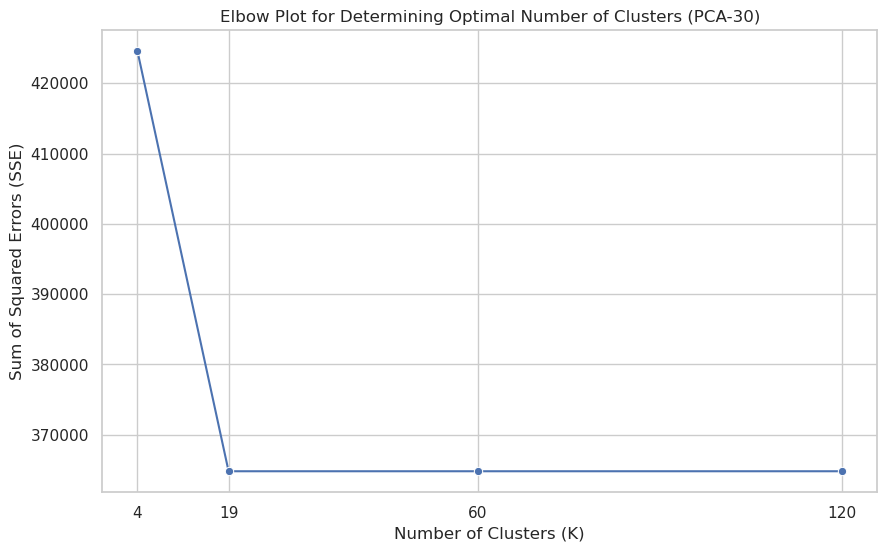

In [27]:
sse_values = []

for k, model_path in model_paths:
    try:
        # Step 1: Download model artifacts from S3
        local_path = f'/tmp/model-k-{k}.tar.gz'
        s3_client.download_file(
            sagemaker_session.default_bucket(),
            model_path.replace(f's3://{sagemaker_session.default_bucket()}/', ''),
            local_path
        )

        # Step 2: Extract model
        with tarfile.open(local_path) as tar:
            tar.extractall(path=f'/tmp/k-{k}')

        # Step 3: Load centroids from MXNet format
        kmeans_model_params = mx.ndarray.load(f'/tmp/k-{k}/model_algo-1')
        centroids = kmeans_model_params[0].asnumpy()

        # Step 4: Efficient distance + SSE computation
        distances = cdist(pca_30, centroids, metric='euclidean')  # shape: [n_samples, k]
        closest_centroids = np.argmin(distances, axis=1)
        sse = np.sum((pca_30 - centroids[closest_centroids])**2)
        sse_values.append(sse)

        # Cleanup to avoid memory buildup
        del distances, centroids, closest_centroids
        gc.collect()

    except Exception as e:
        print(f"Error processing model for K={k}: {e}")

# Step 5: Plot Elbow Chart
sns.set_theme(style="whitegrid")
plt.figure(figsize=(10, 6))
sns.lineplot(x=[k for k, _ in model_paths], y=sse_values, marker='o')
plt.title('Elbow Plot for Determining Optimal Number of Clusters (PCA-30)')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Sum of Squared Errors (SSE)')
plt.xticks([k for k, _ in model_paths])
plt.grid(True)
plt.show()


## 2. Analyze Silhouette Method

Processing K = 4...
Processing K = 19...
Processing K = 60...
Processing K = 120...


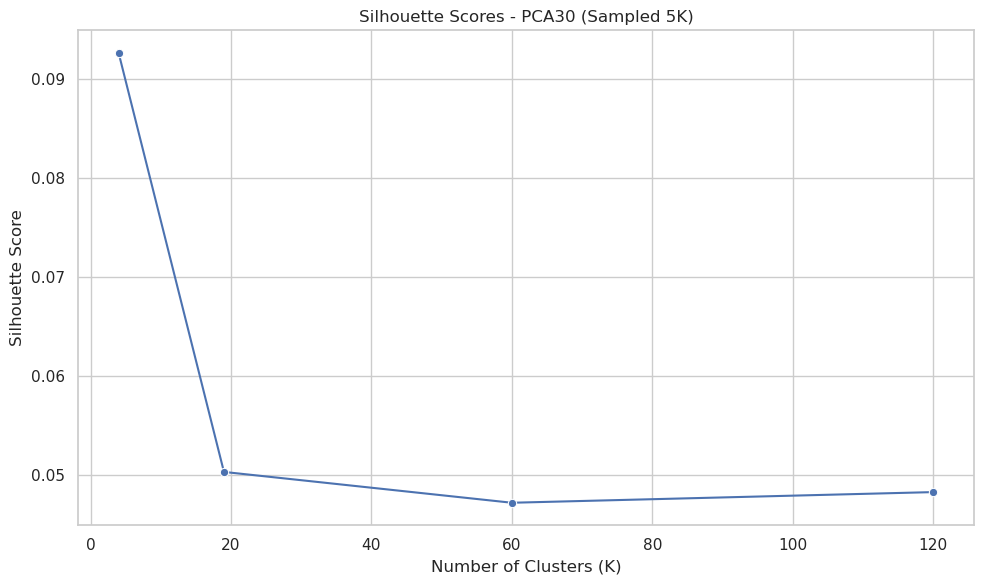

In [28]:
silhouette_scores = []

# Use a consistent random subsample of 5000 points from your PCA data
sample_idx = np.random.choice(len(pca_30), size=5000, replace=False)
pca_sample = pca_30[sample_idx]

for k, model_path in model_paths:
    try:
        print(f"Processing K = {k}...")

        # Download model artifacts
        local_path = f'/tmp/model-k-{k}.tar.gz'
        s3_client.download_file(
            sagemaker_session.default_bucket(),
            model_path.replace(f's3://{sagemaker_session.default_bucket()}/', ''),
            local_path
        )

        # Extract files
        with tarfile.open(local_path) as tar:
            tar.extractall(path=f'/tmp/k-{k}')

        # Load centroids from MXNet model
        kmeans_model_params = mx.ndarray.load(f'/tmp/k-{k}/model_algo-1')
        centroids = kmeans_model_params[0].asnumpy()

        # Compute distances and cluster labels (only on the sample)
        distances = np.linalg.norm(pca_sample[:, np.newaxis] - centroids, axis=2)
        closest_centroids = np.argmin(distances, axis=1)

        # Compute silhouette score
        score = silhouette_score(pca_sample, closest_centroids)
        silhouette_scores.append(score)

        # Clean up memory
        del centroids, distances, closest_centroids, kmeans_model_params
        gc.collect()

    except Exception as e:
        print(f'Error processing model for K={k}: {e}')

# Plot the silhouette scores
if silhouette_scores:
    sns.set_theme(style="whitegrid")
    plt.figure(figsize=(10, 6))
    sns.lineplot(x=[k for k, _ in model_paths], y=silhouette_scores, marker='o')
    plt.title('Silhouette Scores - PCA30 (Sampled 5K)')
    plt.xlabel('Number of Clusters (K)')
    plt.ylabel('Silhouette Score')
    plt.tight_layout()
    plt.show()
else:
    print("No silhouette scores to plot.")


## 3. Visualize the centroids for the optimal K value and display the cluster assignments for each datapoint

 2D Plot of Top-2 PCA Components

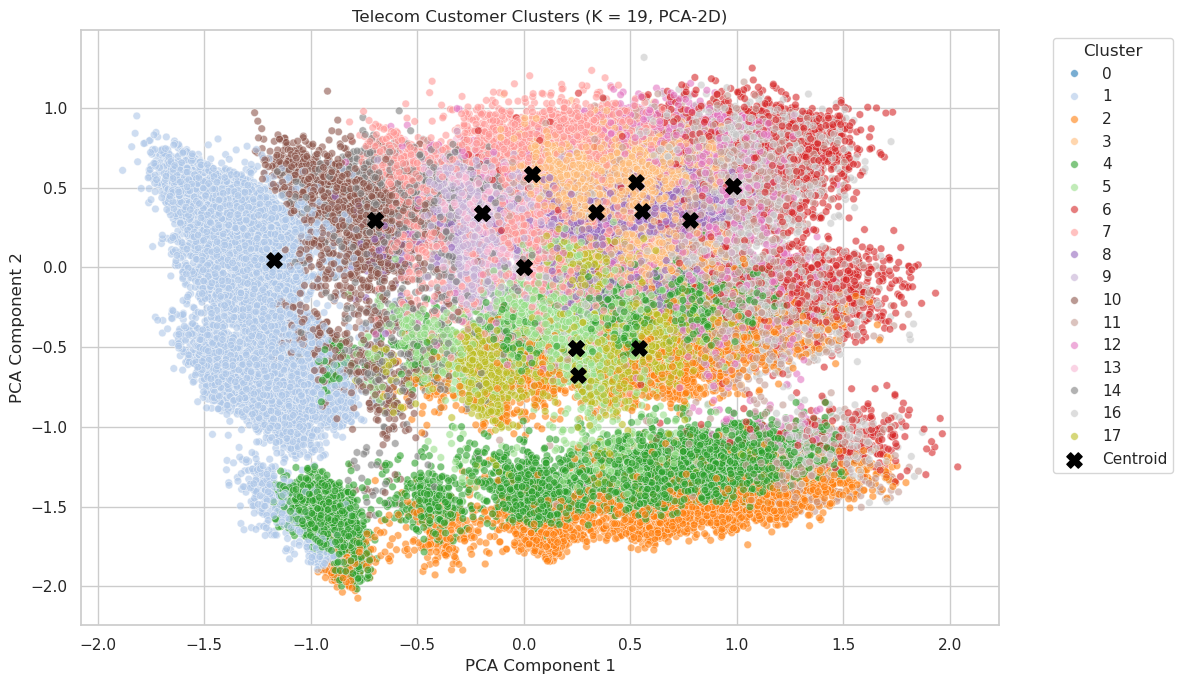

5903

In [30]:

# --- Step 1: Best K Selection ---
best_k = 19
best_model_path = next(path for k, path in model_paths if k == best_k)

# --- Step 2: Download & Extract Model ---
local_path = '/tmp/best_model.tar.gz'
s3_client.download_file(
    sagemaker_session.default_bucket(),
    best_model_path.replace(f's3://{sagemaker_session.default_bucket()}/', ''),
    local_path
)

with tarfile.open(local_path) as tar:
    tar.extractall(path='/tmp/best_model')

# --- Step 3: Load Centroids & Assign Clusters ---
kmeans_best_params = mx.ndarray.load('/tmp/best_model/model_algo-1')
centroids_best = kmeans_best_params[0].asnumpy()
distances_best = np.linalg.norm(pca_30[:, np.newaxis] - centroids_best, axis=2)
cluster_labels = np.argmin(distances_best, axis=1)
df['Cluster'] = cluster_labels

# --- Step 4: Reduce to 2D for Plotting ---
pca = PCA(n_components=2)
pca_2d = pca.fit_transform(pca_30)
centroids_2d = pca.transform(centroids_best)

# --- Step 5: Plotting ---
unique_clusters = np.unique(cluster_labels)
palette = sns.color_palette("tab20", len(unique_clusters))

plt.figure(figsize=(12, 7))
sns.scatterplot(
    x=pca_2d[:, 0], y=pca_2d[:, 1],
    hue=cluster_labels,
    palette=palette,
    legend='full',
    s=30, alpha=0.6
)

# Plot centroids
plt.scatter(centroids_2d[:, 0], centroids_2d[:, 1], s=120, c='black', marker='X', label='Centroid')

# Fix legend layout
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', title='Cluster')
plt.title(f'Telecom Customer Clusters (K = {best_k}, PCA-2D)')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.grid(True)
plt.tight_layout()
plt.show()

# --- Step 6: Memory Cleanup ---
del distances_best, centroids_best, cluster_labels, pca_2d, centroids_2d, kmeans_best_params
gc.collect()

## 4. HPT

[03/30/25 21:18:03] WARNING  No finished training job found associated with this estimator.       ]8;id=571429;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/estimator.py\estimator.py]8;;\:]8;id=378822;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/estimator.py#1914\1914]8;;\
                             Please make sure this estimator is only used for building workflow                    
                             config                                                                                

                    WARNING  No finished training job found associated with this estimator.       ]8;id=266724;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/estimator.py\estimator.py]8;;\:]8;id=217734;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/estimator.py#1914\1914]8;;\
                             Please make sure this estimator is only used for building workflow                    
                             config                                                                                

                    INFO     Creating hyperparameter tuning job with name: kmeans-250330-2118       ]8;id=16991;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/session.py\session.py]8;;\:]8;id=798121;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/session.py#3383\3383]8;;\

............................................................................................!
!

2025-03-30 21:24:54 Starting - Found matching resource for reuse
2025-03-30 21:24:54 Downloading - Downloading the training image
2025-03-30 21:24:54 Training - Training image download completed. Training in progress.
2025-03-30 21:24:54 Uploading - Uploading generated training model
2025-03-30 21:24:54 Completed - Resource reused by training job: kmeans-250330-2118-010-b37affbf


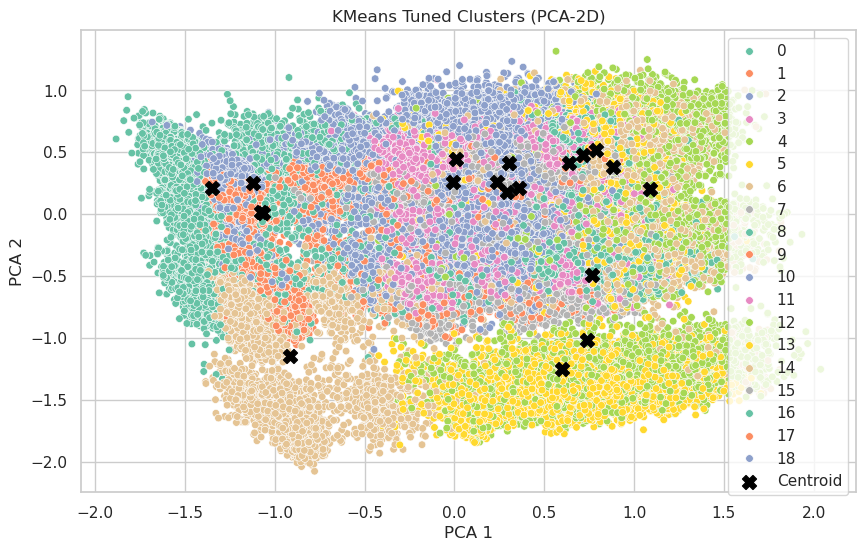

In [36]:

# STEP 1: Split your PCA-30 data
train_data, test_data = train_test_split(pca_30, test_size=0.2, random_state=42)

# STEP 2: Upload to S3 in RecordIO format
def upload_to_s3(array, key):
    buf = io.BytesIO()
    write_numpy_to_dense_tensor(buf, array)
    buf.seek(0)
    s3_client.upload_fileobj(buf, bucket, key)
    return f's3://{bucket}/{key}'

train_key = f'{prefix}/train/train_data.pbr'
test_key = f'{prefix}/test/test_data.pbr'
s3_train_data = upload_to_s3(train_data.astype('float32'), train_key)
s3_test_data = upload_to_s3(test_data.astype('float32'), test_key)

# STEP 3: Estimator (k = fixed, only tuning allowed params)
best_k = 19
kmeans = estimator.Estimator(
    image_uri=image_uri,
    role=role,
    instance_count=1,
    instance_type='ml.m5.large',
    output_path=f's3://{bucket}/{prefix}/output',
    sagemaker_session=sagemaker_session,
    hyperparameters={
        'k': best_k,
        'feature_dim': pca_30.shape[1],
    }
)

# STEP 4: Tunable hyperparameter ranges (only allowed ones!)
hyperparameter_ranges = {
    'init_method': CategoricalParameter(['random', 'kmeans++']),
    'mini_batch_size': IntegerParameter(500, 5000),
    'extra_center_factor': IntegerParameter(4, 10)
}

# STEP 5: Define inputs and tuner
train_input = TrainingInput(s3_data=s3_train_data, content_type='application/x-recordio-protobuf')
test_input = TrainingInput(s3_data=s3_test_data, content_type='application/x-recordio-protobuf')

tuner = HyperparameterTuner(
    estimator=kmeans,
    objective_metric_name='test:msd',  # correct metric
    hyperparameter_ranges=hyperparameter_ranges,
    objective_type='Minimize',
    max_jobs=10,
    max_parallel_jobs=2
)

# STEP 6: Launch tuner
tuner.fit({'train': train_input, 'test': test_input})
tuner.wait()

# STEP 7: Load best model
best_estimator = tuner.best_estimator()
best_model_s3_uri = best_estimator.model_data

# Download model
local_path = '/tmp/best_model.tar.gz'
s3_client.download_file(Bucket=bucket, Key=best_model_s3_uri.replace(f's3://{bucket}/', ''), Filename=local_path)

with tarfile.open(local_path) as tar:
    tar.extractall(path='/tmp/best_model')

# Load centroids and assign clusters
kmeans_best_params = mx.ndarray.load('/tmp/best_model/model_algo-1')
centroids_best = kmeans_best_params[0].asnumpy()
distances_best = np.linalg.norm(pca_30[:, np.newaxis] - centroids_best, axis=2)
cluster_labels = np.argmin(distances_best, axis=1)

# Optional: Visualize
from sklearn.decomposition import PCA
pca_2d = PCA(n_components=2).fit_transform(pca_30)
centroids_2d = PCA(n_components=2).fit(pca_30).transform(centroids_best)

plt.figure(figsize=(10, 6))
sns.scatterplot(x=pca_2d[:, 0], y=pca_2d[:, 1], hue=cluster_labels, palette='Set2', s=30)
plt.scatter(centroids_2d[:, 0], centroids_2d[:, 1], c='black', marker='X', s=100, label='Centroid')
plt.title('KMeans Tuned Clusters (PCA-2D)')
plt.xlabel('PCA 1'); plt.ylabel('PCA 2'); plt.legend(); plt.grid(True)
plt.show()

# E. Evaluate the Model

# F. Deploy the Model

In [38]:
# Step 1: Get the best estimator from HPT
best_estimator = tuner.best_estimator()

# Step 2: Deploy the best model from HPT (no need to manually extract centroids again)
predictor = best_estimator.deploy(
    initial_instance_count=1,
    instance_type='ml.m5.large',
    endpoint_name='kmeans-telecom-pca30-k19-hpt'
)

print(" Model deployed successfully to endpoint: kmeans-telecom-pca30-k19-hpt")


2025-03-30 21:24:54 Starting - Found matching resource for reuse
2025-03-30 21:24:54 Downloading - Downloading the training image
2025-03-30 21:24:54 Training - Training image download completed. Training in progress.
2025-03-30 21:24:54 Uploading - Uploading generated training model
2025-03-30 21:24:54 Completed - Resource reused by training job: kmeans-250330-2118-010-b37affbf


[03/30/25 21:59:01] INFO     Creating model with name: kmeans-2025-03-30-21-59-01-423               ]8;id=80426;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/session.py\session.py]8;;\:]8;id=93798;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/session.py#4094\4094]8;;\

[03/30/25 21:59:02] INFO     Creating endpoint-config with name kmeans-telecom-pca30-k19-hpt        ]8;id=803890;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/session.py\session.py]8;;\:]8;id=971159;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/session.py#5937\5937]8;;\

                    INFO     Creating endpoint with name kmeans-telecom-pca30-k19-hpt               ]8;id=948396;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/session.py\session.py]8;;\:]8;id=146541;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/session.py#4759\4759]8;;\

-------! Model deployed successfully to endpoint: kmeans-telecom-pca30-k19-hpt


# F. Making Inferences

## 1. Cluster Associations and Centroids

In [ ]:
# Initialize a Predictor object for the deployed SageMaker endpoint
predictor = Predictor(endpoint_name=endpoint_name, serializer=CSVSerializer())

def get_user_input(prompt):
    """Function to get user input; allows quitting by typing 'quit'."""
    user_input = input(prompt).strip()
    if user_input.lower() == 'quit':
        return None
    return user_input

def validate_and_prompt(feature_name, feature_prompt):
    """Validate and repeatedly prompt until a valid input or 'quit' is entered."""
    while True:
        user_input = get_user_input(feature_prompt)
        if user_input is None:  # User chose to exit
            return None
        try:
            # Ensure input is within the valid range for Annual Income and Spending Score
            value = float(user_input)
            if feature_name == 'Annual Income' and (0 < value <= 100):
                return str(value)
            elif feature_name == 'Spending Score' and (1 <= value <= 100):
                return str(value)
            else:
                print(f"Please enter a valid {feature_name}.")
        except ValueError:
            print(f"Invalid input. Please enter a number for {feature_name}.")

print("Cluster Prediction Program")
print("Enter your Annual Income and Spending Score for a prediction, or type 'quit' to exit.")

while True:
    # Collect inputs from the user
    annual_income = validate_and_prompt('Annual Income', "Enter Annual Income (k$) or type 'quit' to exit: ")
    if annual_income is None: break
    spending_score = validate_and_prompt('Spending Score', "Enter Spending Score (1-100) or type 'quit' to exit: ")
    if spending_score is None: break

    # Prepare the data for prediction
    data = f'{annual_income},{spending_score}\n'

    # Make prediction and handle potential errors
    try:
        response = predictor.predict(data)
        # Parse the prediction response
        response_json = json.loads(response)
        cluster = response_json['predictions'][0]['closest_cluster']
        distance = response_json['predictions'][0]['distance_to_cluster']
        # Print the cluster assignment
        print(f"The data point belongs to Cluster {int(cluster)} with a distance of {distance:.2f} to the cluster center.")
    except Exception as e:
        print(f"An error occurred during prediction: {str(e)}")

print("Program exited.")


In [ ]:
# Corrected Predictor Code for PCA-30 Input
predictor = Predictor(endpoint_name=endpoint_name, serializer=CSVSerializer())

def get_pca_input():
    print("\nEnter values for each of the 30 PCA components (type 'quit' to exit):")
    inputs = []
    for i in range(30):
        val = input(f"PCA Component {i+1}: ").strip()
        if val.lower() == 'quit':
            return None
        try:
            inputs.append(float(val))
        except ValueError:
            print("Invalid input. Please enter a valid number.")
            return None
    return inputs

print("PCA-Based Cluster Prediction Program (K=19)")
print("Provide 30 PCA component values (after preprocessing) for prediction, or type 'quit' to exit.")

while True:
    user_input = get_pca_input()
    if user_input is None:
        break

    # Convert list to CSV-formatted string
    csv_data = ','.join(map(str, user_input)) + '\n'

    try:
        response = predictor.predict(csv_data)
        response_json = json.loads(response)
        cluster = response_json['predictions'][0]['closest_cluster']
        distance = response_json['predictions'][0]['distance_to_cluster']
        print(f"\n🔹 Predicted Cluster: {int(cluster)} (Distance: {distance:.2f})")
    except Exception as e:
        print(f"Prediction error: {str(e)}")

print("Program exited.")


In [ ]:
# Reconnect to deployed endpoint
predictor = Predictor(endpoint_name=endpoint_name, serializer=CSVSerializer())

# Reuse trained scaler and PCA (make sure you saved them earlier)
scaler = joblib.load('scaler.pkl')       # StandardScaler used before
pca_model = joblib.load('pca_model_30.pkl')  # PCA(n_components=30)

# Function to take row index from the original df and send it for prediction
def predict_cluster_from_index(index):
    try:
        # Extract original features
        row = df.iloc[index]
        encoded = fedf.loc[[row.name]]   # One-hot encoded features
        normalized = scaler.transform(encoded)
        pca_input = pca_model.transform(normalized)

        # Send to SageMaker endpoint
        response = predictor.predict(','.join(map(str, pca_input[0])))

        # Parse response (handle both string or byte output)
        response_json = json.loads(response) if isinstance(response, str) else json.loads(response.decode())
        cluster = response_json['predictions'][0]['closest_cluster']
        distance = response_json['predictions'][0]['distance_to_cluster']
        print(f"Predicted Cluster: {cluster} (Distance: {distance:.2f})")
    except Exception as e:
        print(f"Prediction error: {e}")

# Example: Predict for the first customer
predict_cluster_from_index(0)

Predicted Cluster: 1.0 (Distance: 5.50)


In [ ]:
print("fedf shape:", fedf.shape)
print("fedf dtypes:", fedf.dtypes.value_counts())

# Scale the encoded features
scaler = StandardScaler()
fedf_scaled = scaler.fit_transform(fedf)

# Apply PCA
pca_model = PCA(n_components=30)
pca_model.fit(fedf_scaled)

# Save both the scaler and PCA model
joblib.dump(scaler, 'scaler.pkl')
joblib.dump(pca_model, 'pca_model_30.pkl')

print("Scaler and PCA model saved successfully.")


fedf shape: (97403, 140)
fedf dtypes: float64    71
uint8      66
int64       3
dtype: int64
Scaler and PCA model saved successfully.


# Z. Delete the Endpoint and Endpoint Config

In [ ]:
# Prompt for confirmation before deleting the endpoint and endpoint configuration
confirmation = input("Are you sure you want to delete the endpoint and endpoint configuration? (yes/no): ")

if confirmation.lower() == 'yes':
    # Create a SageMaker client
    sagemaker_client = boto3.client('sagemaker')

    # Check if the endpoint configuration already exists
    try:
        sagemaker_client.describe_endpoint_config(EndpointConfigName=endpoint_config_name)
        print(f'Endpoint configuration "{endpoint_config_name}" already exists. Deleting...')
        sagemaker_client.delete_endpoint_config(EndpointConfigName=endpoint_config_name)
        print(f'Endpoint configuration "{endpoint_config_name}" deleted.')
    except ClientError as e:
        if e.response['Error']['Code'] == 'ValidationException':
            print(f'Endpoint configuration "{endpoint_config_name}" does not exist.')
        else:
            raise

    # Check if the endpoint already exists
    try:
        sagemaker_client.describe_endpoint(EndpointName=endpoint_name)
        print(f'Endpoint "{endpoint_name}" already exists. Deleting...')
        sagemaker_client.delete_endpoint(EndpointName=endpoint_name)
        print(f'Endpoint "{endpoint_name}" deleted.')
    except ClientError as e:
        if e.response['Error']['Code'] == 'ValidationException':
            print(f'Endpoint "{endpoint_name}" does not exist.')
        else:
            raise
else:
    print("Deletion cancelled.")
